In [ ]:
# install python libraries
!pip install pyLDAvis
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8427154a8739cbc971e191d6a298859a92b4d2f1c637c879d8eacdf1b3910bfe
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=21ba8fc4108c2377cf8ae1fa995ed953ec38d5fbf7ae33ff80c92e2101aab500
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████

In [ ]:
# import required libraries

import pandas as pd
import os
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# read article data
data = pd.read_csv('/content/newsarticles.csv',encoding='latin1',engine='python',error_bad_lines=False)

In [ ]:
data.head()

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


In [ ]:
data.shape

(2692, 4)

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text_l = text.split(':')
    if len(text_l)>1:
      text = text_l[1]
    text = text.lower()
    text = text.strip()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)
    return text


# Clean Article Text
data["clean_text"] = data["Article"].apply(lambda x: clean_text(x))

In [ ]:
data.head()

,Article,Date,Heading,NewsType,clean_text
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business,the sindh government has decided to bring down...
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business,asian markets started on an upswing in limit...
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business,hong kong shares opened percent lower mond...
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business,asian markets tumbled tuesday following painfu...
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business,us oil prices monday slipped below a barrel...


###  Models

1.   NMF
2.   LSI
3. HDP





In [ ]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, Nmf
# from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

In [ ]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text
    and pull out only the nouns.'''

    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'

    # store function to split string of words
    # into a list of words (tokens)
    tokenized = word_tokenize(text)

    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()

    # use list comprehension to lemmatize all words
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)]

    # remove words having single character
    all_nouns = [word for word in all_nouns if len(word)>1]

    #return list of nouns
    return all_nouns


# Create dataframe of only nouns from article text
data['nouns'] = data.clean_text.apply(nouns)

In [ ]:
# remove articles which have 2 or less than 2 nouns in it
data = data[data.nouns.apply(len)>2]
data.shape

(2690, 6)

In [ ]:
# create corpus and dictionary
train_texts = data['nouns'].tolist()
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

In [ ]:
# NMF Model
nmfmodel = Nmf(corpus=corpus, num_topics=7, id2word=dictionary, kappa=0.1, eval_every=5)

nmftopics = nmfmodel.show_topics(formatted=False)

In [ ]:
pprint(nmftopics)

[(0,
  [('test', 0.03088817008511207),
   ('year', 0.027942907081025443),
   ('percent', 0.020559201790553462),
   ('month', 0.019790122501374952),
   ('england', 0.014099595738343053),
   ('gold', 0.011956460832366008),
   ('export', 0.011675991921160813),
   ('lanka', 0.007745599026200442),
   ('rate', 0.006937116186165537),
   ('time', 0.0064332221958492645)]),
 (1,
  [('match', 0.02606220778805604),
   ('ball', 0.024419222000360535),
   ('cricket', 0.02017085031872798),
   ('wicket', 0.02001894165177425),
   ('england', 0.017484995031642518),
   ('team', 0.01365660658760022),
   ('run', 0.011629492295983266),
   ('day', 0.011253621927463953),
   ('rate', 0.010322335063656641),
   ('over', 0.010264836808991228)]),
 (2,
  [('oil', 0.04153845096001516),
   ('price', 0.032081300046331286),
   ('market', 0.03074588234136839),
   ('barrel', 0.019578917397569024),
   ('month', 0.018765162506638046),
   ('crude', 0.016167934927518834),
   ('percent', 0.01580954255319491),
   ('week', 0.015

In [ ]:
# LSI Model
lsimodel = LsiModel(corpus=corpus, num_topics=7, id2word=dictionary)

lsitopics = lsimodel.show_topics(formatted=False)

In [ ]:
pprint(lsitopics)

[(0,
  [('percent', 0.43195219539498725),
   ('year', 0.37905099335643794),
   ('oil', 0.2663823008947644),
   ('market', 0.2598728146609036),
   ('price', 0.23441884473041583),
   ('week', 0.15113756131584113),
   ('month', 0.14861389872910707),
   ('rate', 0.12541637867362626),
   ('dollar', 0.12392245756122565),
   ('barrel', 0.1232833525752351)]),
 (1,
  [('test', -0.32009564886155883),
   ('wicket', -0.2643988566343922),
   ('match', -0.254871556927123),
   ('ball', -0.24260271397410185),
   ('england', -0.2163765233927087),
   ('team', -0.21397530659657105),
   ('cricket', -0.2007484531671056),
   ('run', -0.18991204495850755),
   ('pakistan', -0.18250531345072551),
   ('percent', 0.16908471885489662)]),
 (2,
  [('oil', -0.4767503206515696),
   ('price', -0.3176506696742208),
   ('percent', 0.2940880470139654),
   ('year', 0.24674268108008504),
   ('barrel', -0.24667196428234936),
   ('crude', -0.21226522431465022),
   ('tax', 0.1793800493042985),
   ('government', 0.144034835234

In [ ]:
# HDP Model
# An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdptopics = hdpmodel.show_topics(formatted=False)
pprint(hdptopics)

[(0,
  [('test', 0.011576726827761633),
   ('year', 0.01102170581051794),
   ('england', 0.008929456896674053),
   ('match', 0.008684014061840105),
   ('ball', 0.008221136771680328),
   ('day', 0.00817283625262622),
   ('wicket', 0.008102075467544007),
   ('world', 0.00802091124870872),
   ('run', 0.0065775459769977776),
   ('team', 0.006414098528108051),
   ('time', 0.006316598658177281),
   ('pakistan', 0.005533332094027133),
   ('series', 0.005393710370419391),
   ('cricket', 0.005115309653988343),
   ('oil', 0.004901839056973939),
   ('game', 0.004680276758542573),
   ('player', 0.004391077156455262),
   ('percent', 0.00435131418197546),
   ('inning', 0.0040711635575165234),
   ('price', 0.0037210947047360728)]),
 (1,
  [('year', 0.012886825859291018),
   ('percent', 0.012455541310245613),
   ('market', 0.008087429570298446),
   ('oil', 0.00688026710644651),
   ('month', 0.006141438614373931),
   ('price', 0.0058529941699146095),
   ('world', 0.005813339291071078),
   ('week', 0.00

### LDA Model

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=7, id2word=dictionary)
ldatopics = ldamodel.show_topics(formatted=False)
pprint(ldatopics)

[(0,
  [('oil', 0.02045541),
   ('price', 0.015488459),
   ('year', 0.014214039),
   ('barrel', 0.010762487),
   ('percent', 0.010491263),
   ('crude', 0.0103667015),
   ('market', 0.008780395),
   ('production', 0.007967113),
   ('country', 0.007192941),
   ('world', 0.006736671)]),
 (1,
  [('oil', 0.019345542),
   ('price', 0.012953968),
   ('project', 0.01267324),
   ('year', 0.008999539),
   ('company', 0.008954928),
   ('power', 0.00767937),
   ('gas', 0.0070919925),
   ('iran', 0.007080448),
   ('month', 0.006787765),
   ('government', 0.006677705)]),
 (2,
  [('year', 0.009352931),
   ('world', 0.008371255),
   ('bank', 0.007958355),
   ('time', 0.0071623605),
   ('match', 0.0066738143),
   ('game', 0.0060757548),
   ('oil', 0.0058060964),
   ('slam', 0.0044824197),
   ('police', 0.004395715),
   ('market', 0.004299617)]),
 (3,
  [('test', 0.026506381),
   ('cricket', 0.01424138),
   ('england', 0.013939836),
   ('year', 0.013195715),
   ('match', 0.010966605),
   ('team', 0.0108

In [ ]:
#Finding out the optimal number of topics using topic coherence

def evaluate_graph(dictionary, corpus, texts, min_limit, max_limit):
    """
    Function to display num_topics - LDA graph using c_v coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(min_limit, max_limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(min_limit, max_limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

    return lm_list, c_v

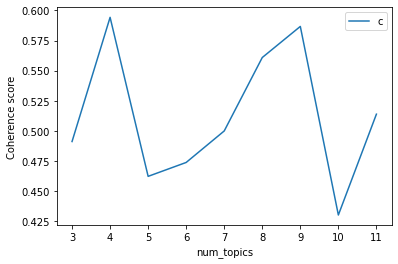

CPU times: user 36 s, sys: 645 ms, total: 36.7 s
Wall time: 36.3 s


In [ ]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, min_limit=3, max_limit=12)

In [ ]:
# best model among optimal number of topics
#kindly choose the index position for best model from above graph
idx = 1
lda_best_topics = lmlist[idx].show_topics(formatted=False)#lmlist = all topic models


In [ ]:
pprint(lda_best_topics)

[(0,
  [('year', 0.013021795),
   ('country', 0.008492272),
   ('pakistan', 0.0071591944),
   ('percent', 0.007013217),
   ('trade', 0.0067362995),
   ('minister', 0.0067303427),
   ('day', 0.005332292),
   ('investment', 0.005259541),
   ('match', 0.0047299056),
   ('month', 0.0044600917)]),
 (1,
  [('percent', 0.018772718),
   ('oil', 0.016581414),
   ('year', 0.014156616),
   ('price', 0.011743697),
   ('market', 0.01146356),
   ('country', 0.00863281),
   ('bank', 0.0067658373),
   ('month', 0.006598039),
   ('china', 0.0064113284),
   ('state', 0.0062412815)]),
 (2,
  [('year', 0.015505622),
   ('team', 0.013207507),
   ('test', 0.01226014),
   ('world', 0.011256568),
   ('time', 0.010808075),
   ('match', 0.010319586),
   ('game', 0.010209686),
   ('cricket', 0.009505742),
   ('england', 0.009437094),
   ('pakistan', 0.008519012)]),
 (3,
  [('test', 0.017808044),
   ('wicket', 0.015231856),
   ('ball', 0.011668373),
   ('england', 0.011629669),
   ('year', 0.011366698),
   ('run'

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [ ]:
# visualizing the model which had best coherence score from above #topics evaluation

# trying model having 5 number of topics as it gave best coherence score in above chart
pyLDAvis.gensim_models.prepare(lmlist[idx], corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.136745  0.006694       1        1  41.384420
2     -0.084531 -0.050635       2        1  27.437047
3     -0.092853  0.052298       3        1  18.911817
0      0.040639 -0.008356       4        1  12.266717, topic_info=         Term         Freq        Total Category  logprob  loglift
3517     test  1696.000000  1696.000000  Default  30.0000  30.0000
6963   wicket  1086.000000  1086.000000  Default  29.0000  29.0000
4478  england  1181.000000  1181.000000  Default  28.0000  28.0000
4315    match  1266.000000  1266.000000  Default  27.0000  27.0000
5939     ball   966.000000   966.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
3517     test   110.099038  1696.618105   Topic4  -5.5506  -0.6367
157      time   101.870554  1311.102906   Topic4  -5.6282  -0.4566
109    market   101.489925  1435.746761   Topic4  -5.6320  -0.5512
20      price   100.777597  1415.362239   Topic4  -5.6390  -0.5439
6963   wicket    89.401684  1086.778543   Topic4  -5.7588  -0.3996

[357 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5479       1  0.066438  accident
5479       2  0.033219  accident
5479       3  0.332188  accident
5479       4  0.564720  accident
13667      4  0.721467  achakzai
...      ...       ...       ...
10087      1  0.122183     zakir
10087      4  0.855282     zakir
14649      4  0.944037    great
14650      4  0.944037      man
3277       4  0.843869       pm

[840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [ ]:
# One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers.
# Let us try to dig out the best topics from the best LDA model we can produce.
# The function below can be used to control the quality of the LDA model we produce.

In [ ]:
#lda_top_model

threshold = 0.6 # you can change to a higher number but it will take more time

def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed.

    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < threshold:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [ ]:
%%time
lm, top_topics = ret_top_model()

CPU times: user 2min 10s, sys: 4.55 s, total: 2min 15s
Wall time: 2min 11s


In [ ]:
print(top_topics[:5])

[(65, 0.7977632775711564), (19, 0.7628945944848178), (67, 0.6935853149461766), (84, 0.687187786908394), (21, 0.627090892447269)]


In [ ]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:5]])

[[('oil', 0.05874982),
  ('barrel', 0.035278104),
  ('crude', 0.031626776),
  ('production', 0.03034908),
  ('bpd', 0.02976889),
  ('price', 0.027693342),
  ('opec', 0.027407747),
  ('output', 0.022484792),
  ('month', 0.019117296),
  ('cut', 0.018443385)],
 [('test', 0.054337908),
  ('wicket', 0.03983714),
  ('england', 0.03305589),
  ('inning', 0.032944407),
  ('run', 0.029333366),
  ('ball', 0.028087653),
  ('root', 0.023182278),
  ('cook', 0.020282045),
  ('woakes', 0.014028556),
  ('day', 0.013447855)],
 [('ball', 0.03593023),
  ('wicket', 0.02279839),
  ('run', 0.012214723),
  ('england', 0.011152662),
  ('stump', 0.0104549),
  ('over', 0.00981363),
  ('perera', 0.009783158),
  ('century', 0.009674904),
  ('four', 0.008887227),
  ('match', 0.0078755235)],
 [('wicket', 0.04158948),
  ('series', 0.024405064),
  ('ball', 0.02339562),
  ('match', 0.023133354),
  ('over', 0.022888444),
  ('pakistan', 0.020036593),
  ('run', 0.019538097),
  ('inning', 0.017970217),
  ('england', 0.0171

In [ ]:
#lda_top_topics = lm.show_topic(topicid) for topicid, c_v in top_topics

### Evaluating all topics model

In [ ]:
#NMF
nmftopics_1 = [[word for word, prob in topic] for topicid, topic in nmftopics]

#LSI
lsitopics_1 = [[word for word, prob in topic] for topicid, topic in lsitopics]

#HDP
hdptopics_1 = [[word for word, prob in topic] for topicid, topic in hdptopics]

#LDA
ldatopics_1 = [[word for word, prob in topic] for topicid, topic in ldatopics]

# best LDA from optimal number of topics evaluation using topic coherence
lda_best_topics_1 = [[word for word, prob in topic] for topicid, topic in lda_best_topics]

# top LDA model based on user defined topic coherence threshold (we gave 0.6)
lda_top_topics_1 = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

In [ ]:

nmf_coherence = CoherenceModel(topics=nmftopics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lsi_coherence = CoherenceModel(topics=lsitopics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics_1, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_best_coherence = CoherenceModel(topics=lda_best_topics_1, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_top_coherence = CoherenceModel(topics=lda_top_topics_1[:7], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [ ]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.

    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

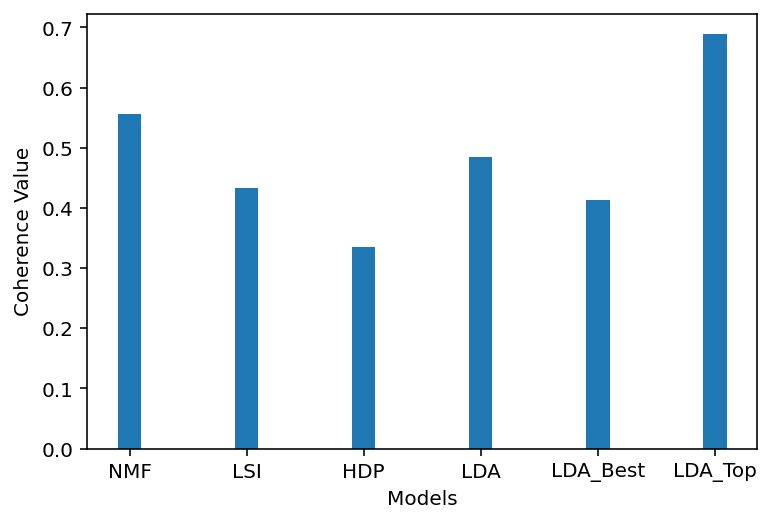

In [ ]:
evaluate_bar_graph([nmf_coherence, lsi_coherence, hdp_coherence, lda_coherence, lm_best_coherence, lda_top_coherence],
                   ['NMF', 'LSI', 'HDP', 'LDA', 'LDA_Best', 'LDA_Top'])

### NMF Topic Modeling using scikit learn (you can ignore)

In [ ]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text
    and pull out only the nouns.'''
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    # store function to split string of words
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)]

    #return string of joined list of nouns
    return ' '.join(all_nouns)


# Create dataframe of only nouns from articles text
data['nouns'] = data.clean_text.apply(nouns)

In [ ]:
# Add additional stop words since we are recreating the document-term matrix
# stop_noun = ["strong", 'DUBAI', 'WASHINGTON', 'BEIJING']
# stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)
stopwords = stopwords.words('english')

# Create a document-term matrix with only nouns
# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=stopwords, ngram_range = (1,2), max_df = .8, min_df = .01)

# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data.nouns)

In [ ]:
# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names())

# Visually inspect Document Term Matrix
data_dtm_noun.head()

,aaron,ab,ab villiers,ability,absence,access,account,achievement,act,action,...,yen,yen york,yield,york,younis,yuan,zalmi,zealand,zimbabwe,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.055148,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.123566,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091386,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def display_topics(model, feature_names, num_top_words, topic_names=None):
  '''
  Given an NMF model, feature_names, and number of top words,
  print topic number and its top feature names, up to specified number of top words.
  '''
  # iterate through topics in topic-term matrix, 'H' aka
  # model.components_
  for ix, topic in enumerate(model.components_):
      #print topic, topic number, and top words
      if not topic_names or not topic_names[ix]:
          print("\nTopic ", ix)
      else:
          print("\nTopic: '",topic_names[ix],"'")
      print(", ".join([feature_names[i] \
            for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
nmf_model = NMF(7) # change the number of topics by entering the number of your choice

# Learn an NMF model for given Document Term Matrix 'V'
# Extract the document-topic matrix 'W'
doc_topic = nmf_model.fit_transform(data_dtm_noun)

# Extract top words from the topic-term matrix 'H'
display_topics(nmf_model, tv_noun.get_feature_names_out(), 7) #change the number if you wish to see more terms within each topic


Topic  0
game, world, time, minute, goal, year, champion

Topic  1
test, england, series, day, cook, inning, lanka

Topic  2
oil, price, barrel, crude, market, production, oil price

Topic  3
percent, market, rate, dollar, index, stock, bank

Topic  4
minister, government, pakistan, tax, country, power, finance

Topic  5
wicket, ball, run, four, match, six, bowler

Topic  6
cricket, team, pakistan, pcb, india, board, pakistan cricket
